# Notebook for adding in TFs

Alyssa's 3/4/2019

- 3/7/2019 Fixed loss function to mask missing values
- 3/7/2017 Started to implement rotating cell types

# Imports

In [1006]:
import collections
import datetime

import pyDNase
import tensorflow as tf
import h5py
from scipy.io import loadmat

import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics
import os
import pybedtools
import torch
import h5sparse
import datetime
import logging

from scipy import stats

from pyDNase import GenomicInterval
from scipy.sparse import coo_matrix, vstack

from scipy.fftpack import fft, ifft

import sys

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)


In [235]:
import logging

# get TF logger
log = logging.getLogger('tensorflow')
log.setLevel(logging.INFO)

# create formatter and add it to the handlers
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# create file handler which logs even debug messages
fh = logging.FileHandler('/data/akmorrow/tensorflow.log')
fh.setLevel(logging.INFO)
fh.setFormatter(formatter)
log.addHandler(fh)

In [ ]:
# path to where dnase bams are stored. Bams need to be sorted and indexed. See bin/download_dnase_encode.sh for
# data processing
# Required in constants.py
_ENCODE_DATA_PREFIX =  "/data/akmorrow/encode_data/"

# where training data is stored
deepsea_path = "/data/akmorrow/epitome_data/deepsea_train/"

# Define Paths for this user

In [995]:
exec(open("./constants.py").read())
exec(open("./functions.py").read())
exec(open("./generators.py").read())
exec(open("./models.py").read())

# Load Data

### Load DeepSEA data

In [1015]:
# generated from original data by save_deepsea_label_data(deepsea_path) in functions.py
train_data, valid_data, test_data = load_deepsea_label_data("/data/akmorrow/epitome_data/deepsea_labels_train/")

In [1016]:
print(valid_data["y"].shape, train_data["y"].shape, test_data["y"].shape)

(919, 408000) (919, 4455024) (919, 455024)


# Validation and Test Cell Types

In [968]:
# Available cell types. Calculated from Train_data_analysis.ipynb
# if you do this, none left to test on!
#validation_celltypes = ['K562', 'HepG2', 'H1-hESC', 'GM12891', 'HeLa-S3', 'T-47D']
#test_celltypes = ['A549', 'GM12878', 'ProgFib', 'HUVEC', 'NT2-D1', 'MCF-7']
validation_celltypes = ['K562', 'HepG2']
test_celltypes = ['A549']


assays = ['DNase', 'p300', 'c-Myc', 'c-Jun', 'c-Fos', 'Znf143', 'ZZZ3', 'ZNF274', 'ZBTB7A', 'ZBTB33', 'YY1', 'USF2', 'USF-1', 'TR4', 'TFIIIC-110', 'TEAD4', 'TCF7L2', 'TCF12', 'TBP', 'TBLR1', 'TAF7', 'TAF1', 'Sin3Ak-20', 'SUZ12', 'STAT5A', 'STAT3', 'STAT1', 'SRF', 'SP2', 'SP1', 'SMC3', 'SIX5', 'SIN3A', 'Rad21', 'RXRA', 'RPC155', 'RFX5', 'RBBP5', 'Pol3', 'Pol2-4H8', 'Pol2(phosphoS2)', 'Pol2(b)', 'Pol2', 'PU.1', 'POU2F2', 'PML', 'PAX5-C20', 'Nrf1', 'NRSF', 'NFKB', 'NFIC', 'NF-YB', 'NF-YA', 'NF-E2', 'Mxi1', 'Max', 'MafK', 'MafF', 'MEF2A', 'MAZ', 'JunD', 'Ini1', 'IRF3', 'HDAC2', 'HA-E2F1', 'GTF2F1', 'GATA3', 'GATA-2', 'GABP', 'FOXA1', 'FOSL2', 'FOSL1', 'Egr-1', 'EZH2', 'ETS1', 'ELK1', 'ELF1', 'E2F6', 'E2F4', 'CTCF', 'COREST', 'CHD2', 'CHD1', 'CEBPB', 'Brg1', 'Bach1', 'BRF2', 'BRF1', 'BRCA1', 'BHLHE40', 'BDP1', 'BCLAF1', 'BCL3', 'BCL11A', 'ATF3', 'ATF2', 'ARID3A']

# test: is code working right?
validation_celltypes = ['Gliobla']
test_celltypes = ['GM12878']
#assays = ['DNase',  'Rad21', 'CTCF', 'Pol2']
celltypes = ['SK-N-SH_RA', 'K562', 'HepG2', 'HeLa-S3', 'H1-hESC', 'GM12878', 'A549']
# celltypes = ['K562', 'HepG2', 'HeLa-S3', 'H1-hESC', 'GM12878', 'A549']

## Get matrix of cell types and assays

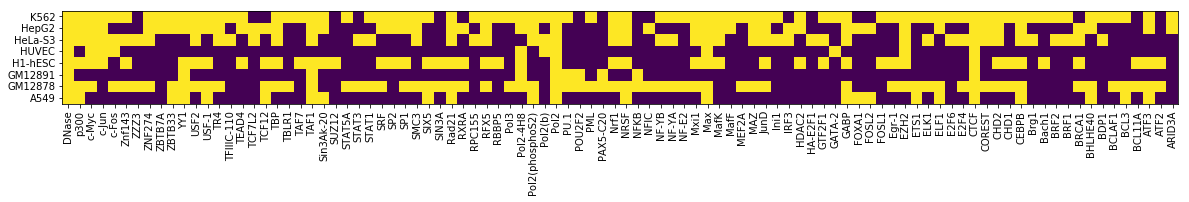

In [976]:
matrix, cellmap, assaymap = get_assays_from_feature_file(feature_path='../data/feature_name', 
                                  eligible_assays = assays,
                                  eligible_cells = None, min_assays=10)
        
inv_assaymap = {v: k for k, v in assaymap.items()}

fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.xticks(np.arange(len(assaymap)), rotation = 90)
ax.set_xticklabels(assaymap.keys())
plt.yticks(np.arange(len(cellmap)))
ax.set_yticklabels(cellmap.keys())

plt.imshow(matrix!=-1)
# print(list(cellmap.keys()), list(assaymap.keys()))

# matrix

# Run the Model

In [997]:
test_celltypes = ['GM12878']
model = MLP(4, [100, 100, 100, 50], 
            tf.tanh, 
            train_data, 
            valid_data, 
            test_data, 
            test_celltypes,
            gen_from_peaks, 
            matrix,
            assaymap,
            cellmap,
            shuffle_size=2, 
            radii=[1,3,10,30])
model.train(2000)


eval cell types ['K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'H1-hESC', 'GM12891', 'A549']
using ['K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'H1-hESC', 'GM12891', 'A549'] as labels for mode Dataset.TRAIN
using ['K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'H1-hESC', 'GM12891', 'A549'] as labels for mode Dataset.VALID
using ['GM12878'] as labels for mode Dataset.TEST
INFO:tensorflow:Scale of 0 disables regularizer.


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Initializing variables
INFO:tensorflow:Starting Training
INFO:tensorflow:1000 0.007644514
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.8097462902883549
INFO:tensorflow:Our micro AUC:     0.8097462902883549
INFO:tensorflow:p300:	AUC:0.793	avPR:0.066	GINI:0.368
INFO:tensorflow:c-Myc:	AUC:0.884	avPR:0.142	GINI:0.219
INFO:tensorflow:c-Jun:	AUC:0.849	avPR:0.035	GINI:0.201
INFO:tensorflow:c-Fos:	AUC:0.889	avPR:0.071	GINI:-0.025
INFO:tensorflow:Znf143:	AUC:0.900	avPR:0.277	GINI:0.410
INFO:tensorflow:ZZZ3:	AUC:nan	avPR:nan	GINI:-0.250
INFO:tensorflow:ZNF274:	AUC:0.322	avPR:0.000	GINI:-0.202
INFO:tensorflow:ZBTB7A:	AUC:0.824	avPR:0.174	GINI:0.270
INFO:tensorflow:ZBTB33:	AUC:0.911	avPR:0.092	GINI:0.202
INFO:tensorflow:YY1:	AUC:0.893	avPR:0.260	GINI:0.622
INFO:tensorflow:USF2:	AUC:0.839	avPR:0.048	GINI:0.195
INFO:tensorflow:USF-1:	AUC:0.821	avPR:0.130	GINI:0.363
INFO:tensorflow:TR4:	AUC:0.897	avPR:0.187	GINI:-0.010
INFO:tensorflow:TFIIIC-110:	AUC:0.813	avPR:0

INFO:tensorflow:Nrf1:	AUC:0.958	avPR:0.203	GINI:-0.210
INFO:tensorflow:NRSF:	AUC:0.719	avPR:0.058	GINI:0.238
INFO:tensorflow:NFKB:	AUC:0.594	avPR:0.171	GINI:0.101
INFO:tensorflow:NFIC:	AUC:0.823	avPR:0.089	GINI:-0.054
INFO:tensorflow:NF-YB:	AUC:0.792	avPR:0.098	GINI:-0.095
INFO:tensorflow:NF-YA:	AUC:0.848	avPR:0.136	GINI:-0.111
INFO:tensorflow:NF-E2:	AUC:0.914	avPR:0.029	GINI:-0.305
INFO:tensorflow:Mxi1:	AUC:0.856	avPR:0.258	GINI:0.311
INFO:tensorflow:Max:	AUC:0.872	avPR:0.191	GINI:0.663
INFO:tensorflow:MafK:	AUC:0.610	avPR:0.018	GINI:0.015
INFO:tensorflow:MafF:	AUC:0.586	avPR:0.049	GINI:-0.060
INFO:tensorflow:MEF2A:	AUC:0.842	avPR:0.093	GINI:-0.318
INFO:tensorflow:MAZ:	AUC:0.925	avPR:0.320	GINI:0.346
INFO:tensorflow:JunD:	AUC:0.775	avPR:0.117	GINI:0.310
INFO:tensorflow:Ini1:	AUC:0.732	avPR:0.051	GINI:-0.102
INFO:tensorflow:IRF3:	AUC:0.957	avPR:0.036	GINI:0.012
INFO:tensorflow:HDAC2:	AUC:0.747	avPR:0.078	GINI:-0.021
INFO:tensorflow:HA-E2F1:	AUC:0.972	avPR:0.278	GINI:-0.012
INFO:tensorf

In [998]:
test_DNase = model.test(40000, mode = Dataset.TEST, log=True)

INFO:tensorflow:Our macro AUC:     0.871200299730094
INFO:tensorflow:Our micro AUC:     0.871200299730094
INFO:tensorflow:p300:	AUC:0.797	avPR:0.045	GINI:0.595
INFO:tensorflow:c-Myc:	AUC:0.945	avPR:0.094	GINI:0.890
INFO:tensorflow:c-Jun:	AUC:nan	avPR:nan	GINI:nan
INFO:tensorflow:c-Fos:	AUC:0.992	avPR:0.098	GINI:0.983
INFO:tensorflow:Znf143:	AUC:0.973	avPR:0.301	GINI:0.947
INFO:tensorflow:ZZZ3:	AUC:0.676	avPR:0.026	GINI:0.352
INFO:tensorflow:ZNF274:	AUC:NaN	avPR:NaN	GINI:NaN
INFO:tensorflow:ZBTB7A:	AUC:nan	avPR:nan	GINI:nan
INFO:tensorflow:ZBTB33:	AUC:0.958	avPR:0.223	GINI:0.916
INFO:tensorflow:YY1:	AUC:0.824	avPR:0.017	GINI:0.648
INFO:tensorflow:USF2:	AUC:0.898	avPR:0.083	GINI:0.796
INFO:tensorflow:USF-1:	AUC:0.900	avPR:0.095	GINI:0.800
INFO:tensorflow:TR4:	AUC:0.658	avPR:0.010	GINI:0.316
INFO:tensorflow:TFIIIC-110:	AUC:nan	avPR:nan	GINI:nan
INFO:tensorflow:TEAD4:	AUC:nan	avPR:nan	GINI:nan
INFO:tensorflow:TCF7L2:	AUC:nan	avPR:nan	GINI:nan
INFO:tensorflow:TCF12:	AUC:0.869	avPR:0.125	GIN

In [983]:
model.save("/data/akmorrow/epitome_data/saved_models/test_model_full_2.ckpt")


INFO:tensorflow:Model saved in path: /data/akmorrow/epitome_data/saved_models/test_model_full_2.ckpt


# GM12878 UNKS

INFO:tensorflow:Our macro AUC:     0.9466272794702281
INFO:tensorflow:Our micro AUC:     0.9466272794702281
INFO:tensorflow:Rad21:	AUC:0.966	avPR:0.654	GINI:0.932
INFO:tensorflow:Pol2:	AUC:0.888	avPR:0.444	GINI:0.776
INFO:tensorflow:CTCF:	AUC:0.986	avPR:0.747	GINI:0.972

# Restore Model

In [241]:
model2  = MLP(4, [100, 100, 100, 50], 
            tf.tanh, 
            train_data, 
            valid_data, 
            test_data, 
            validation_celltypes,
            test_celltypes,
            gen_from_peaks, 
            matrix,
            assaymap,
            cellmap,
            shuffle_size=2, 
            radii=[1,3,10,30])
model2.restore("/data/akmorrow/epitome_data/saved_models/test_model_full_2.ckpt")

INFO:tensorflow:Scale of 0 disables regularizer.


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [243]:
x = model2.test(40000, mode = Dataset.TEST, log=True)

INFO:tensorflow:Failed to calculate macro AUC
INFO:tensorflow:Failed to calculate micro AUC
2019-03-05 11:53:43.136928 0 DNase
INFO:tensorflow:2019-03-05 11:53:43.137011: 0, DNase, NaN
INFO:tensorflow:p300:	AUC:0.494	avPR:0.014	GINI:0.653
INFO:tensorflow:c-Myc:	AUC:0.567	avPR:0.004	GINI:0.697
INFO:tensorflow:c-Jun:	AUC:0.470	avPR:0.013	GINI:0.685
INFO:tensorflow:c-Fos:	AUC:0.538	avPR:0.014	GINI:0.497
INFO:tensorflow:Znf143:	AUC:0.458	avPR:0.006	GINI:0.447


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


INFO:tensorflow:ZZZ3:	AUC:nan	avPR:nan	GINI:0.429
INFO:tensorflow:ZNF274:	AUC:0.509	avPR:0.001	GINI:0.463


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


INFO:tensorflow:ZBTB7A:	AUC:nan	avPR:nan	GINI:nan
INFO:tensorflow:ZBTB33:	AUC:0.600	avPR:0.003	GINI:0.496
INFO:tensorflow:YY1:	AUC:0.550	avPR:0.003	GINI:0.241
INFO:tensorflow:USF2:	AUC:0.459	avPR:0.003	GINI:0.726
INFO:tensorflow:USF-1:	AUC:0.460	avPR:0.004	GINI:0.326
INFO:tensorflow:TR4:	AUC:0.478	avPR:0.002	GINI:0.695


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


INFO:tensorflow:TFIIIC-110:	AUC:nan	avPR:nan	GINI:nan


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


INFO:tensorflow:TEAD4:	AUC:nan	avPR:nan	GINI:nan
INFO:tensorflow:TCF7L2:	AUC:0.561	avPR:0.004	GINI:0.758
INFO:tensorflow:TCF12:	AUC:0.501	avPR:0.012	GINI:0.455
INFO:tensorflow:TBP:	AUC:0.547	avPR:0.009	GINI:0.335
INFO:tensorflow:TBLR1:	AUC:0.518	avPR:0.009	GINI:0.516


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


INFO:tensorflow:TAF7:	AUC:nan	avPR:nan	GINI:nan
INFO:tensorflow:TAF1:	AUC:0.604	avPR:0.005	GINI:0.288
INFO:tensorflow:Sin3Ak-20:	AUC:0.505	avPR:0.004	GINI:0.573
INFO:tensorflow:SUZ12:	AUC:0.506	avPR:0.004	GINI:0.587
INFO:tensorflow:STAT5A:	AUC:0.558	avPR:0.013	GINI:0.319
INFO:tensorflow:STAT3:	AUC:0.533	avPR:0.006	GINI:0.527
INFO:tensorflow:STAT1:	AUC:0.358	avPR:0.000	GINI:0.384
INFO:tensorflow:SRF:	AUC:0.547	avPR:0.002	GINI:0.525


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


INFO:tensorflow:SP2:	AUC:nan	avPR:nan	GINI:nan
INFO:tensorflow:SP1:	AUC:0.563	avPR:0.008	GINI:0.366
INFO:tensorflow:SMC3:	AUC:0.689	avPR:0.049	GINI:0.521
INFO:tensorflow:SIX5:	AUC:0.579	avPR:0.004	GINI:0.453
INFO:tensorflow:SIN3A:	AUC:0.567	avPR:0.006	GINI:0.346
INFO:tensorflow:Rad21:	AUC:0.639	avPR:0.017	GINI:0.458
INFO:tensorflow:RXRA:	AUC:0.435	avPR:0.000	GINI:0.416


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


INFO:tensorflow:RPC155:	AUC:nan	avPR:nan	GINI:nan
INFO:tensorflow:RFX5:	AUC:0.367	avPR:0.001	GINI:0.502


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


INFO:tensorflow:RBBP5:	AUC:nan	avPR:nan	GINI:nan


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


INFO:tensorflow:Pol3:	AUC:nan	avPR:nan	GINI:0.499
INFO:tensorflow:Pol2-4H8:	AUC:0.548	avPR:0.020	GINI:0.499
INFO:tensorflow:Pol2(phosphoS2):	AUC:0.529	avPR:0.003	GINI:0.503
INFO:tensorflow:Pol2(b):	AUC:0.431	avPR:0.004	GINI:0.285
INFO:tensorflow:Pol2:	AUC:0.511	avPR:0.005	GINI:0.483
INFO:tensorflow:PU.1:	AUC:0.487	avPR:0.016	GINI:0.435
INFO:tensorflow:POU2F2:	AUC:0.491	avPR:0.012	GINI:0.432
INFO:tensorflow:PML:	AUC:0.515	avPR:0.016	GINI:0.302
INFO:tensorflow:PAX5-C20:	AUC:0.492	avPR:0.012	GINI:0.943
INFO:tensorflow:Nrf1:	AUC:0.436	avPR:0.002	GINI:0.440
INFO:tensorflow:NRSF:	AUC:0.535	avPR:0.007	GINI:0.642
INFO:tensorflow:NFKB:	AUC:0.432	avPR:0.009	GINI:0.462
INFO:tensorflow:NFIC:	AUC:0.527	avPR:0.029	GINI:0.443
INFO:tensorflow:NF-YB:	AUC:0.486	avPR:0.005	GINI:0.494
INFO:tensorflow:NF-YA:	AUC:0.460	avPR:0.001	GINI:0.664


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


INFO:tensorflow:NF-E2:	AUC:nan	avPR:nan	GINI:0.554
INFO:tensorflow:Mxi1:	AUC:0.495	avPR:0.010	GINI:0.303
INFO:tensorflow:Max:	AUC:0.477	avPR:0.004	GINI:0.279


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


INFO:tensorflow:MafK:	AUC:nan	avPR:nan	GINI:nan


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


INFO:tensorflow:MafF:	AUC:nan	avPR:nan	GINI:nan
INFO:tensorflow:MEF2A:	AUC:0.422	avPR:0.009	GINI:0.488
INFO:tensorflow:MAZ:	AUC:0.505	avPR:0.008	GINI:0.307
INFO:tensorflow:JunD:	AUC:0.428	avPR:0.001	GINI:0.288


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


INFO:tensorflow:Ini1:	AUC:nan	avPR:nan	GINI:nan


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


INFO:tensorflow:IRF3:	AUC:nan	avPR:nan	GINI:nan


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


INFO:tensorflow:HDAC2:	AUC:nan	avPR:nan	GINI:nan
INFO:tensorflow:HA-E2F1:	AUC:0.509	avPR:0.009	GINI:0.839


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


INFO:tensorflow:GTF2F1:	AUC:nan	avPR:nan	GINI:nan
INFO:tensorflow:GATA3:	AUC:0.472	avPR:0.002	GINI:0.414
INFO:tensorflow:GATA-2:	AUC:0.472	avPR:0.021	GINI:0.524
INFO:tensorflow:GABP:	AUC:0.509	avPR:0.006	GINI:0.336
INFO:tensorflow:FOXA1:	AUC:0.496	avPR:0.002	GINI:0.870
INFO:tensorflow:FOSL2:	AUC:0.538	avPR:0.019	GINI:0.559


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


INFO:tensorflow:FOSL1:	AUC:nan	avPR:nan	GINI:nan
INFO:tensorflow:Egr-1:	AUC:0.555	avPR:0.011	GINI:0.408
INFO:tensorflow:EZH2:	AUC:0.553	avPR:0.004	GINI:0.384
INFO:tensorflow:ETS1:	AUC:0.476	avPR:0.001	GINI:0.785
INFO:tensorflow:ELK1:	AUC:0.479	avPR:0.001	GINI:0.577
INFO:tensorflow:ELF1:	AUC:0.567	avPR:0.007	GINI:0.408


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


INFO:tensorflow:E2F6:	AUC:nan	avPR:nan	GINI:nan
INFO:tensorflow:E2F4:	AUC:0.572	avPR:0.001	GINI:0.614
INFO:tensorflow:CTCF:	AUC:0.519	avPR:0.018	GINI:0.420
INFO:tensorflow:COREST:	AUC:0.504	avPR:0.001	GINI:0.287
INFO:tensorflow:CHD2:	AUC:0.489	avPR:0.007	GINI:0.369
INFO:tensorflow:CHD1:	AUC:0.566	avPR:0.006	GINI:0.216
INFO:tensorflow:CEBPB:	AUC:0.512	avPR:0.015	GINI:0.519


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


INFO:tensorflow:Brg1:	AUC:nan	avPR:nan	GINI:nan


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


INFO:tensorflow:Bach1:	AUC:nan	avPR:nan	GINI:nan


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


INFO:tensorflow:BRF2:	AUC:nan	avPR:nan	GINI:nan


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


INFO:tensorflow:BRF1:	AUC:nan	avPR:nan	GINI:nan


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


INFO:tensorflow:BRCA1:	AUC:nan	avPR:nan	GINI:0.674
INFO:tensorflow:BHLHE40:	AUC:0.503	avPR:0.004	GINI:0.342


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


INFO:tensorflow:BDP1:	AUC:nan	avPR:nan	GINI:nan
INFO:tensorflow:BCLAF1:	AUC:0.484	avPR:0.005	GINI:0.748
INFO:tensorflow:BCL3:	AUC:0.497	avPR:0.008	GINI:0.689
INFO:tensorflow:BCL11A:	AUC:0.548	avPR:0.012	GINI:0.671
INFO:tensorflow:ATF3:	AUC:0.545	avPR:0.003	GINI:0.450
INFO:tensorflow:ATF2:	AUC:0.521	avPR:0.024	GINI:0.769
